This code performs the following tasks:

Reads a dataset of coin flip sequences from a file. Each sequence consists of a sequence of coin flips, where 'H' represents Heads (1) and 'T' represents Tails (0).

Creates an instance of a Hidden Markov Model (HMM) with 2 hidden states.

Trains the HMM using the Baum-Welch algorithm (an instance of the Expectation-Maximization algorithm) on the coin flip sequences. During training, the HMM learns the parameters that best describe the underlying probabilistic process generating the coin flips.

Computes and prints the log likelihood of the observed coin flip sequences under the trained HMM. This log likelihood measures how well the HMM can explain the observed data.

Sets the HMM's parameters to some predefined "true" values (used for demonstration purposes) and computes the log likelihood of the data under these true parameters.

Demonstrates the Viterbi algorithm to find the most likely state sequence for the first observed coin flip sequence. The Viterbi algorithm identifies the sequence of hidden states (e.g., whether the coin was in a biased or unbiased state) that most likely generated the observed coin flips.

In summary, this code trains a Hidden Markov Model on coin flip data, evaluates its ability to explain the data, and demonstrates how to use it to infer hidden states (e.g., biased or unbiased coin) from observed sequences of coin flips. The HMM can be thought of as a probabilistic model that captures the underlying dynamics of the coin flipping process.

initial A: [[0.7087962  0.2912038 ]
 [0.29152056 0.70847944]]
initial B: [[0.62969057 0.37030943]
 [0.58883752 0.41116248]]
it: 0


C:\Users\asus\AppData\Local\Temp\ipykernel_16268\2112171053.py:80: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(N)) / N


it: 10
it: 20
A: [[0.70386662 0.29613338]
 [0.28712763 0.71287237]]
B: [[0.54419694 0.45580306]
 [0.53723247 0.46276753]]
pi: [0.50695647 0.49304353]
Fit duration: 0:00:01.388352


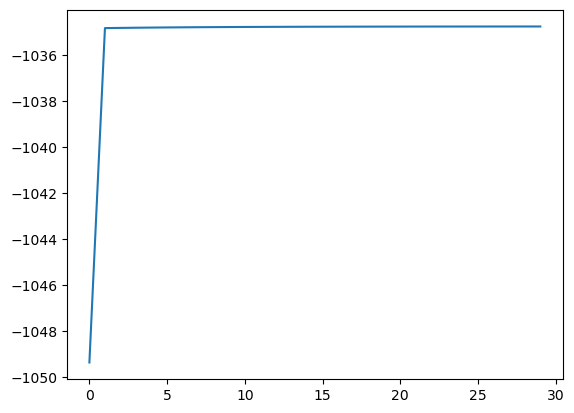

LL with fitted params: -1034.7557547352071
LL with true params: -1059.7229160265022
Best state sequence for: [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [2]:
# https://deeplearningcourses.com/c/unsupervised-machine-learning-hidden-markov-models-in-python
# https://udemy.com/unsupervised-machine-learning-hidden-markov-models-in-python
# http://lazyprogrammer.me
# Discrete Hidden Markov Model (HMM)
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


def random_normalized(d1, d2):
    x = np.random.random((d1, d2))
    return x / x.sum(axis=1, keepdims=True)


class HMM:
    def __init__(self, M):
        self.M = M # number of hidden states
    
    def fit(self, X, max_iter=30):
        t0 = datetime.now()
        np.random.seed(123)
        # train the HMM model using the Baum-Welch algorithm
        # a specific instance of the expectation-maximization algorithm

        # determine V, the vocabulary size
        # assume observables are already integers from 0..V-1
        # X is a jagged array of observed sequences
        V = max(max(x) for x in X) + 1
        N = len(X)

        self.pi = np.ones(self.M) / self.M # initial state distribution
        self.A = random_normalized(self.M, self.M) # state transition matrix
        self.B = random_normalized(self.M, V) # output distribution

        print("initial A:", self.A)
        print("initial B:", self.B)

        costs = []
        for it in range(max_iter):
            if it % 10 == 0:
                print("it:", it)
            alphas = []
            betas = []
            P = np.zeros(N)
            for n in range(N):
                x = X[n]
                T = len(x)
                alpha = np.zeros((T, self.M))
                alpha[0] = self.pi*self.B[:,x[0]]
                for t in range(1, T):
                    tmp1 = alpha[t-1].dot(self.A) * self.B[:, x[t]]
                    # tmp2 = np.zeros(self.M)
                    # for i in range(self.M):
                    #     for j in range(self.M):
                    #         tmp2[j] += alpha[t-1,i] * self.A[i,j] * self.B[j, x[t]]
                    # print "diff:", np.abs(tmp1 - tmp2).sum()
                    alpha[t] = tmp1
                P[n] = alpha[-1].sum()
                alphas.append(alpha)

                beta = np.zeros((T, self.M))
                beta[-1] = 1
                for t in range(T - 2, -1, -1):
                    beta[t] = self.A.dot(self.B[:, x[t+1]] * beta[t+1])
                betas.append(beta)

            # print "P:", P
            # break
            assert(np.all(P > 0))
            cost = np.sum(np.log(P))
            costs.append(cost)

            # now re-estimate pi, A, B
            self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(N)) / N
            # print "self.pi:", self.pi
            # break

            den1 = np.zeros((self.M, 1))
            den2 = np.zeros((self.M, 1))
            a_num = 0
            b_num = 0
            for n in range(N):
                x = X[n]
                T = len(x)
                # print "den shape:", den.shape
                # test = (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims=True).T
                # print "shape (alphas[n][:-1] * betas[n][:-1]).sum(axis=0): ", test.shape
                den1 += (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims=True).T / P[n]
                den2 += (alphas[n] * betas[n]).sum(axis=0, keepdims=True).T / P[n]

                # tmp2 = np.zeros((self.M, 1))
                # for i in range(self.M):
                #     for t in range(T-1):
                #         tmp2[i] += alphas[n][t,i] * betas[n][t,i]
                # tmp2 /= P[n]
                # # print "diff:", np.abs(tmp1 - tmp2).sum()
                # den += tmp1

                # numerator for A
                a_num_n = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T-1):
                            a_num_n[i,j] += alphas[n][t,i] * self.A[i,j] * self.B[j, x[t+1]] * betas[n][t+1,j]
                a_num += a_num_n / P[n]

                # numerator for B
                # b_num_n = np.zeros((self.M, V))
                # for i in range(self.M):
                #     for j in range(V):
                #         for t in range(T):
                #             if x[t] == j:
                #                 b_num_n[i,j] += alphas[n][t][i] * betas[n][t][i]
                b_num_n2 = np.zeros((self.M, V))
                for i in range(self.M):
                    for t in range(T):
                        b_num_n2[i,x[t]] += alphas[n][t,i] * betas[n][t,i]
                b_num += b_num_n2 / P[n]
            # tmp1 = a_num / den1
            # tmp2 = np.zeros(a_num.shape)
            # for i in range(self.M):
            #     for j in range(self.M):
            #         tmp2[i,j] = a_num[i,j] / den1[i]
            # print "diff:", np.abs(tmp1 - tmp2).sum()
            # print "tmp1:", tmp1
            # print "tmp2:", tmp2
            self.A = a_num / den1
            self.B = b_num / den2
            # print "P:", P
            # break
        print("A:", self.A)
        print("B:", self.B)
        print("pi:", self.pi)

        print("Fit duration:", (datetime.now() - t0))

        plt.plot(costs)
        plt.show()

    def likelihood(self, x):
        # returns log P(x | model)
        # using the forward part of the forward-backward algorithm
        T = len(x)
        alpha = np.zeros((T, self.M))
        alpha[0] = self.pi*self.B[:,x[0]]
        for t in range(1, T):
            alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]
        return alpha[-1].sum()

    def likelihood_multi(self, X):
        return np.array([self.likelihood(x) for x in X])

    def log_likelihood_multi(self, X):
        return np.log(self.likelihood_multi(X))

    def get_state_sequence(self, x):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        T = len(x)
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        delta[0] = self.pi*self.B[:,x[0]]
        for t in range(1, T):
            for j in range(self.M):
                delta[t,j] = np.max(delta[t-1]*self.A[:,j]) * self.B[j, x[t]]
                psi[t,j] = np.argmax(delta[t-1]*self.A[:,j])

        # backtrack
        states = np.zeros(T, dtype=np.int32)
        states[T-1] = np.argmax(delta[T-1])
        for t in range(T-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states

def fit_coin():
    X = []
    for line in open('coin_data.txt'):
        # 1 for H, 0 for T
        x = [1 if e == 'H' else 0 for e in line.rstrip()]
        X.append(x)

    hmm = HMM(2)
    hmm.fit(X)
    L = hmm.log_likelihood_multi(X).sum()
    print("LL with fitted params:", L)

    # try true values
    hmm.pi = np.array([0.5, 0.5])
    hmm.A = np.array([[0.1, 0.9], [0.8, 0.2]])
    hmm.B = np.array([[0.6, 0.4], [0.3, 0.7]])
    L = hmm.log_likelihood_multi(X).sum()
    print("LL with true params:", L)

    # try viterbi
    print("Best state sequence for:", X[0])
    print(hmm.get_state_sequence(X[0]))


if __name__ == '__main__':
    fit_coin()